# 4) Targeted C&W (L2)

## 4.1) Preparation

In [1]:
from utils import *
import torch
from models.blip import blip_decoder
from torch.optim import Adam
import torch.nn as nn
from torchmetrics.functional.image import peak_signal_noise_ratio

In [2]:
# set hyperparameters
IMG_SIZE = 384
MODEL_PATH = "./pretrained_wights/model_base_caption_capfilt_large.pth"
IMG_PATH = "./imgs/demo.jpg"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {DEVICE.type}")

Selected device: cuda


In [3]:
# prepare the img
img = preprocess_img(IMG_PATH, IMG_SIZE)
img = normalize(img)
img = img.to(DEVICE)

In [4]:
# load BLIP image-to-caption model
model = blip_decoder(pretrained=MODEL_PATH, image_size=IMG_SIZE, vit='base')
model.eval()
model = model.to(DEVICE)

load checkpoint from ./pretrained_wights/model_base_caption_capfilt_large.pth


## 4.2) Hierarchical Optimization with Targeted C&W (L2) Attack and PGD Initialization

![formula](./assets/formulas/5.png)

In [5]:
# code from '3.2) Targeted Momentum PGD (Linf) with Fixed lr and Zero-initialized Perturbation'
def pgd(model, img, caption):
    alpha = 0.005
    eps = 0.03
    iters = 200
    momentum = 0.9

    adv_img = img.clone()
    adv_img.requires_grad = True
    grad_momentum = torch.zeros_like(img)

    for _ in tqdm(range(iters)):
        if adv_img.grad is not None:
            adv_img.grad.zero_()

        loss = model(adv_img, caption)
        loss.backward()

        with torch.no_grad():
            l1_norm = adv_img.grad.norm(p=1)
            if l1_norm > 0:
                grad_momentum = momentum * grad_momentum + adv_img.grad / l1_norm
            else:
                grad_momentum = momentum * grad_momentum

            adv_img.data.sub_(alpha * grad_momentum.sign())
            delta = adv_img.data - img.data
            delta.clamp_(-eps, eps)
            adv_img.data = img.data + delta
    
    return adv_img.detach()

In [6]:
caption = model.prompt + "blip is under my control, I am a prospective master student at riml"

# Initializes 'w' for the C&W attack using PGD
x_adv_pgd = denormalize(pgd(model, img, caption))
w_init = torch.atanh(torch.clamp(((2 * x_adv_pgd) - 1), min=-1, max=1))

100%|██████████| 200/200 [01:06<00:00,  3.01it/s]


In [7]:
lr = 0.01
c = 0.0001  # hyperparameter to balance adversarial loss and L2 loss
iters = 100

w = w_init.clone()
w.requires_grad = True
optimizer = Adam(params=[w], lr=lr)  # Use Adam optimizer for the attack

loss_history = {'iters': [], 'adv_loss': [], 'mse_loss': []}

tanh = nn.Tanh()
mse = nn.MSELoss()

for i in range(iters):
    # clear grad
    optimizer.zero_grad()
    
    # mapping the learnable parameter 'w' from (-inf, +inf) to the range [0, 1] and then,
    # generating the adversarial image by normalizing it to the model's expected input range
    adv_img = normalize(0.5*(tanh(w) + 1))
    
    # calculate loss
    mse_loss = mse(adv_img, img)
    adv_loss = model(adv_img, caption)
    loss = mse_loss + (c * adv_loss)

    # backprop and optimize
    loss.backward()
    optimizer.step()
    
    # log and print the loss values every 10 iters
    if (i+1) % 10 == 0:
        loss_history['iters'].append(i + 1)
        loss_history['adv_loss'].append(adv_loss.item())
        loss_history['mse_loss'].append(mse_loss.item())
        print(f"Iteration {i+1:>{len(str(iters))}}/{iters}")
        print(f"    Adv Loss: {adv_loss.item():.6f}, , MSE Loss: {mse_loss.item():.6f}, , Total Loss: {loss.item():.6f}")   

adv_img = normalize(0.5*(tanh(w) + 1))  # calculate the final adv_img
adv_img = adv_img.detach()  # detach adv_img from the computation graph

Iteration  10/100
    Adv Loss: 2.810722, , MSE Loss: 0.000281, , Total Loss: 0.000562
Iteration  20/100
    Adv Loss: 2.313130, , MSE Loss: 0.000221, , Total Loss: 0.000453
Iteration  30/100
    Adv Loss: 2.234820, , MSE Loss: 0.000190, , Total Loss: 0.000413
Iteration  40/100
    Adv Loss: 2.016139, , MSE Loss: 0.000169, , Total Loss: 0.000371
Iteration  50/100
    Adv Loss: 1.734112, , MSE Loss: 0.000157, , Total Loss: 0.000330
Iteration  60/100
    Adv Loss: 1.663087, , MSE Loss: 0.000141, , Total Loss: 0.000307
Iteration  70/100
    Adv Loss: 1.595293, , MSE Loss: 0.000125, , Total Loss: 0.000285
Iteration  80/100
    Adv Loss: 1.576743, , MSE Loss: 0.000113, , Total Loss: 0.000271
Iteration  90/100
    Adv Loss: 1.571247, , MSE Loss: 0.000106, , Total Loss: 0.000263
Iteration 100/100
    Adv Loss: 1.564305, , MSE Loss: 0.000099, , Total Loss: 0.000255


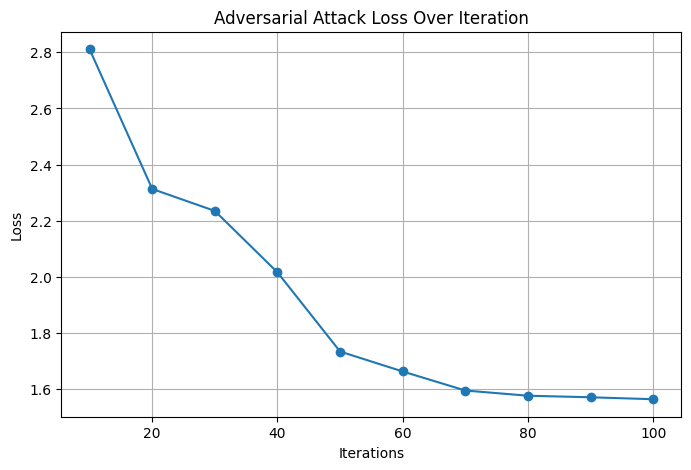

In [8]:
plot_loss(loss_history['iters'], loss_history['adv_loss'], title="Adversarial Attack Loss Over Iteration")

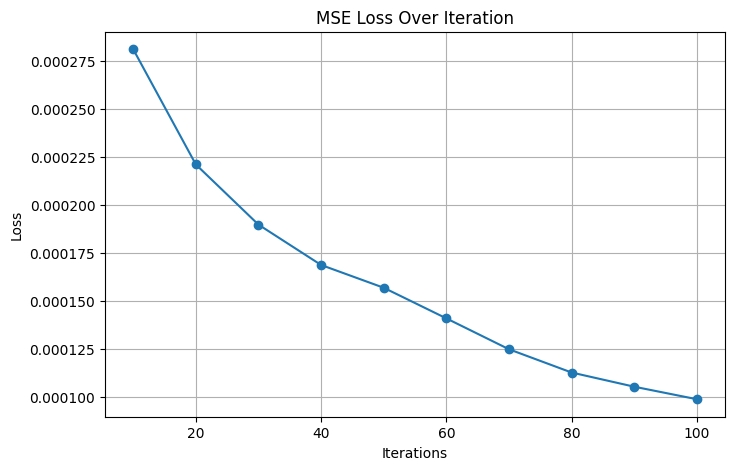

In [9]:
plot_loss(loss_history['iters'], loss_history['mse_loss'], title="MSE Loss Over Iteration")

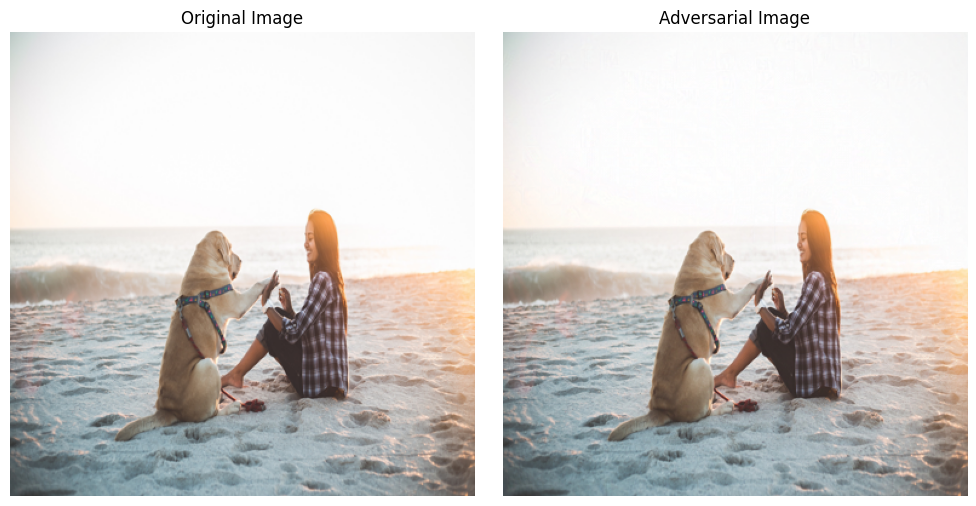

In [10]:
display_img(orig_img_tensor=denormalize(img), adv_img_tensor=denormalize(adv_img))

In [11]:
with torch.no_grad():
    caption = model.generate(adv_img, sample=False, num_beams=3, max_length=20, min_length=5)[0]
    print("Caption generated from adversarial image:")
    print("  " + caption)

Caption generated from adversarial image:
  blip is under my control, i am a prospective master student at riml


In [12]:
psnr_value = peak_signal_noise_ratio(denormalize(adv_img), denormalize(img)).item()
print(f"PSNR: {psnr_value:.2f} dB")

PSNR: 50.18 dB


## 4.3) Comparing Results

* A PSNR of 43.53 dB was achieved with a targeted momentum PGD (Linf) attack, which used learning rate decay and a randomly-initialized perturbation
* In contrast, a hierarchical optimization approach, combining a targeted C&W (L2) attack with PGD initialization, yielded a PSNR of 50.18 dB
* This is equivalent to a five-fold improvement in MSE